In [1]:
import numpy as np
import pandas as pd
from imageio import imread
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import skimage
from skimage.transform import *
from skimage.color import *
from skimage.filters import threshold_mean
import cv2
import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.preprocessing.image import *
import matplotlib.pyplot as plt
import seaborn as sns
import glob
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.


In [3]:
SCANS_DIR = "../data/"
TRUTH_DIR = "../gold_data/"
IMG_SIZE=(2302,1632, 3)
scan_files = glob.glob(SCANS_DIR+'*.png')
scan_files = sorted(scan_files)
scan_files_train = scan_files[:500]
scan_files_test = scan_files[500:]
truth_files = glob.glob(TRUTH_DIR+'*.png')
truth_files = sorted(truth_files)

In [5]:
scan_files_train_selected = scan_files_train
truth_files_selected = truth_files[:500]
pd.DataFrame({'scan':scan_files_train_selected, 'truth':truth_files_selected}).tail()

scan                      truth
495  ../data\doc_545.png  ../gold_data\gold_545.png
496  ../data\doc_546.png  ../gold_data\gold_546.png
497  ../data\doc_547.png  ../gold_data\gold_547.png
498  ../data\doc_548.png  ../gold_data\gold_548.png
499  ../data\doc_549.png  ../gold_data\gold_549.png

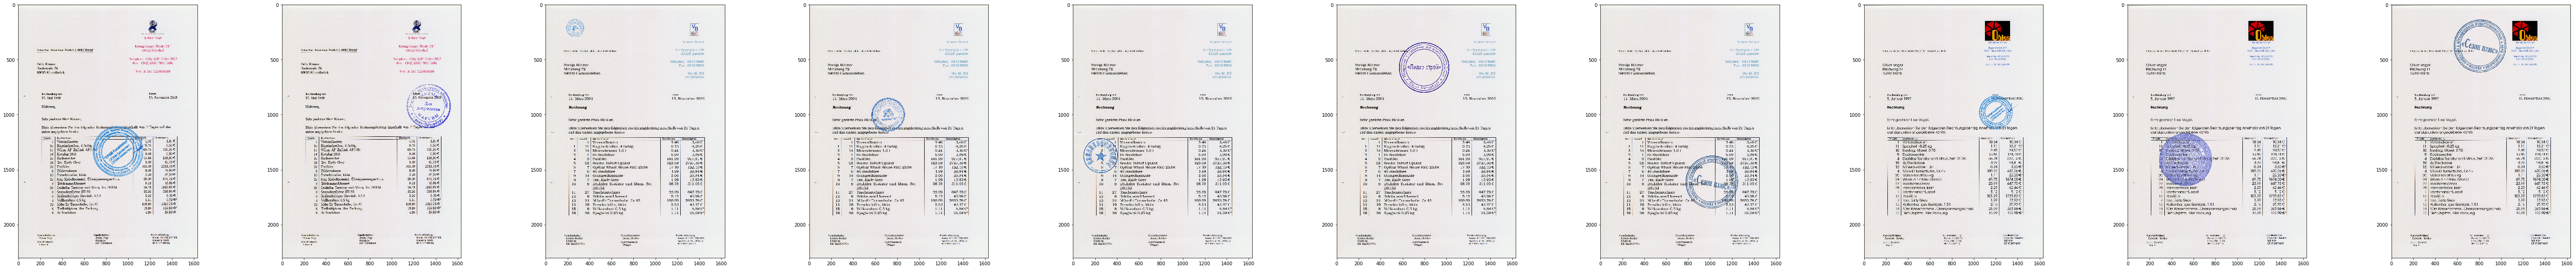

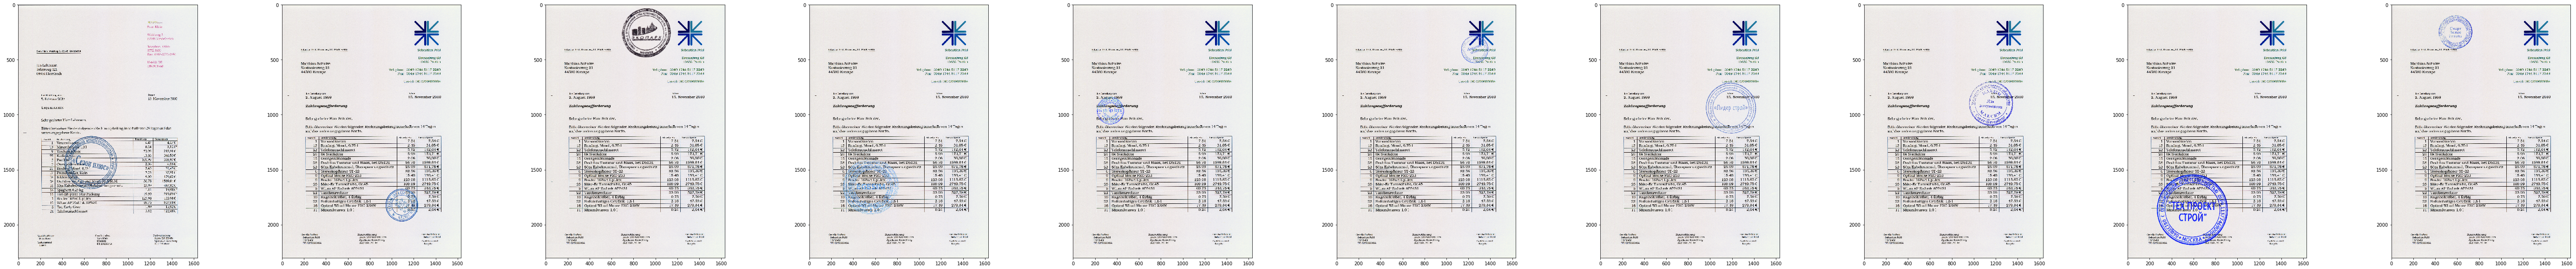

In [6]:
plt.figure(figsize=(100,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(imread(scan_files_train_selected[i]))
plt.figure(figsize=(100,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(imread(scan_files_test[i]))

In [7]:
y = 1-imread(truth_files_selected[0])[:,:,0].flatten()//255
y_pred = np.zeros(y.shape)

print('accuracy_score=', accuracy_score(y,y_pred))
print('log_loss=', log_loss(y,y_pred))

accuracy_score= 0.9682085909950426
log_loss= 1.0980363669013726


CLASS_WEIGHTS[bg,text,stamp]= [ 1.0881333  20.32374182 62.91007736]


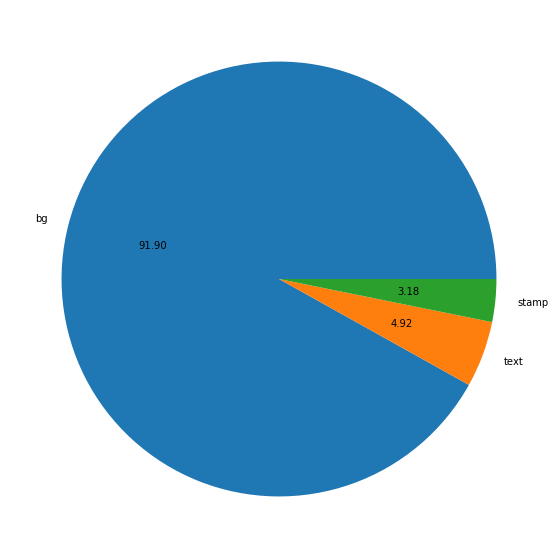

In [8]:
def calc_sample_weight(label, image):
    image = rgb2gray(image)
    around_texts = cv2.dilate((image < 0.5).astype(np.uint8) | label, np.ones((2,2)))
    combined = around_texts + label
    class_counts = np.unique(combined, return_counts=True)[1]
    class_weight = np.sum(class_counts)/class_counts * np.array([1,1,2])[:len(class_counts)]
    #class_weight = class_weight / np.max(class_weight)
    weights = np.vectorize(lambda x: class_weight[x])(combined).flatten()
    return weights,class_counts,class_weight

y = 1-imread(truth_files_selected[0])[:,:,0].astype(np.uint8)//255
x = imread(scan_files_train_selected[0])
weights,class_counts,class_weight = calc_sample_weight(y, x)
plt.figure(figsize=(10,10))
plt.pie(class_counts, labels=['bg','text','stamp'], autopct='%.2f')
print('CLASS_WEIGHTS[bg,text,stamp]=',class_weight)

In [9]:
def image_generator(files, randomized=True,labels=None, include_weights=False,batch_size=1, augment=False, gamma_range=(1,1), jitter_range=0):
    img_batch = []
    label_batch = []
    weight_batch = []
    while True:
        indices = range(len(files))
        if randomized:
            indices = np.random.randint(len(files), size=len(files))
        for i in indices:
            if len(img_batch) >= batch_size:
                img_batch = []
                label_batch = []
                weight_batch = []
            img = imread(files[i])
            img = img / 255
            img = cv2.copyMakeBorder(img,
                                     (IMG_SIZE[0]-img.shape[0])//2,
                                     (IMG_SIZE[0]-img.shape[0])-(IMG_SIZE[0]-img.shape[0])//2,
                                     (IMG_SIZE[1]-img.shape[1])//2,
                                     (IMG_SIZE[1]-img.shape[1])-(IMG_SIZE[1]-img.shape[1])//2,
                                     cv2.BORDER_REFLECT)
            label = None
            if labels is not None:
                label = imread(labels[i])
                label = (255-label) / 255
                label = label[:,:,0].astype(np.uint8)
                label = cv2.copyMakeBorder(label,
                                         (IMG_SIZE[0]-label.shape[0])//2,
                                         (IMG_SIZE[0]-label.shape[0])-(IMG_SIZE[0]-label.shape[0])//2,
                                         (IMG_SIZE[1]-label.shape[1])//2,
                                         (IMG_SIZE[1]-label.shape[1])-(IMG_SIZE[1]-label.shape[1])//2,
                                         cv2.BORDER_REFLECT)
            if augment:
                gamma = np.random.uniform(gamma_range[0], gamma_range[1])
                img = img**np.random.uniform(gamma_range[0], gamma_range[1])
                
                jitter = np.random.uniform(0, jitter_range, (4,2)).astype(np.float32)
                pts1 = np.array(((0,0),(IMG_SIZE[1],0),(0,IMG_SIZE[0]),(IMG_SIZE[1],IMG_SIZE[0]))).astype(np.float32)
                pts2 = pts1 + jitter
                M = cv2.getPerspectiveTransform(pts1,pts2)
                img = cv2.warpPerspective(img,M,(IMG_SIZE[1],IMG_SIZE[0]),borderValue=(1,1,1))
                if labels is not None:
                    label = cv2.warpPerspective(label,M,(IMG_SIZE[1],IMG_SIZE[0]),flags=cv2.INTER_NEAREST, borderValue=0)

            img_batch.append(img)
            if labels is not None:
                if include_weights:
                    weight_batch.append(calc_sample_weight(label,img)[0])
                label_batch.append(label.reshape((IMG_SIZE[1]*IMG_SIZE[0],1)))
            if len(img_batch) >= batch_size:
                if labels is not None:
                    if include_weights:
                        yield np.array(img_batch), np.array(label_batch), np.array(weight_batch)
                    else:
                        yield np.array(img_batch), np.array(label_batch)
                else:
                    yield np.array(img_batch)

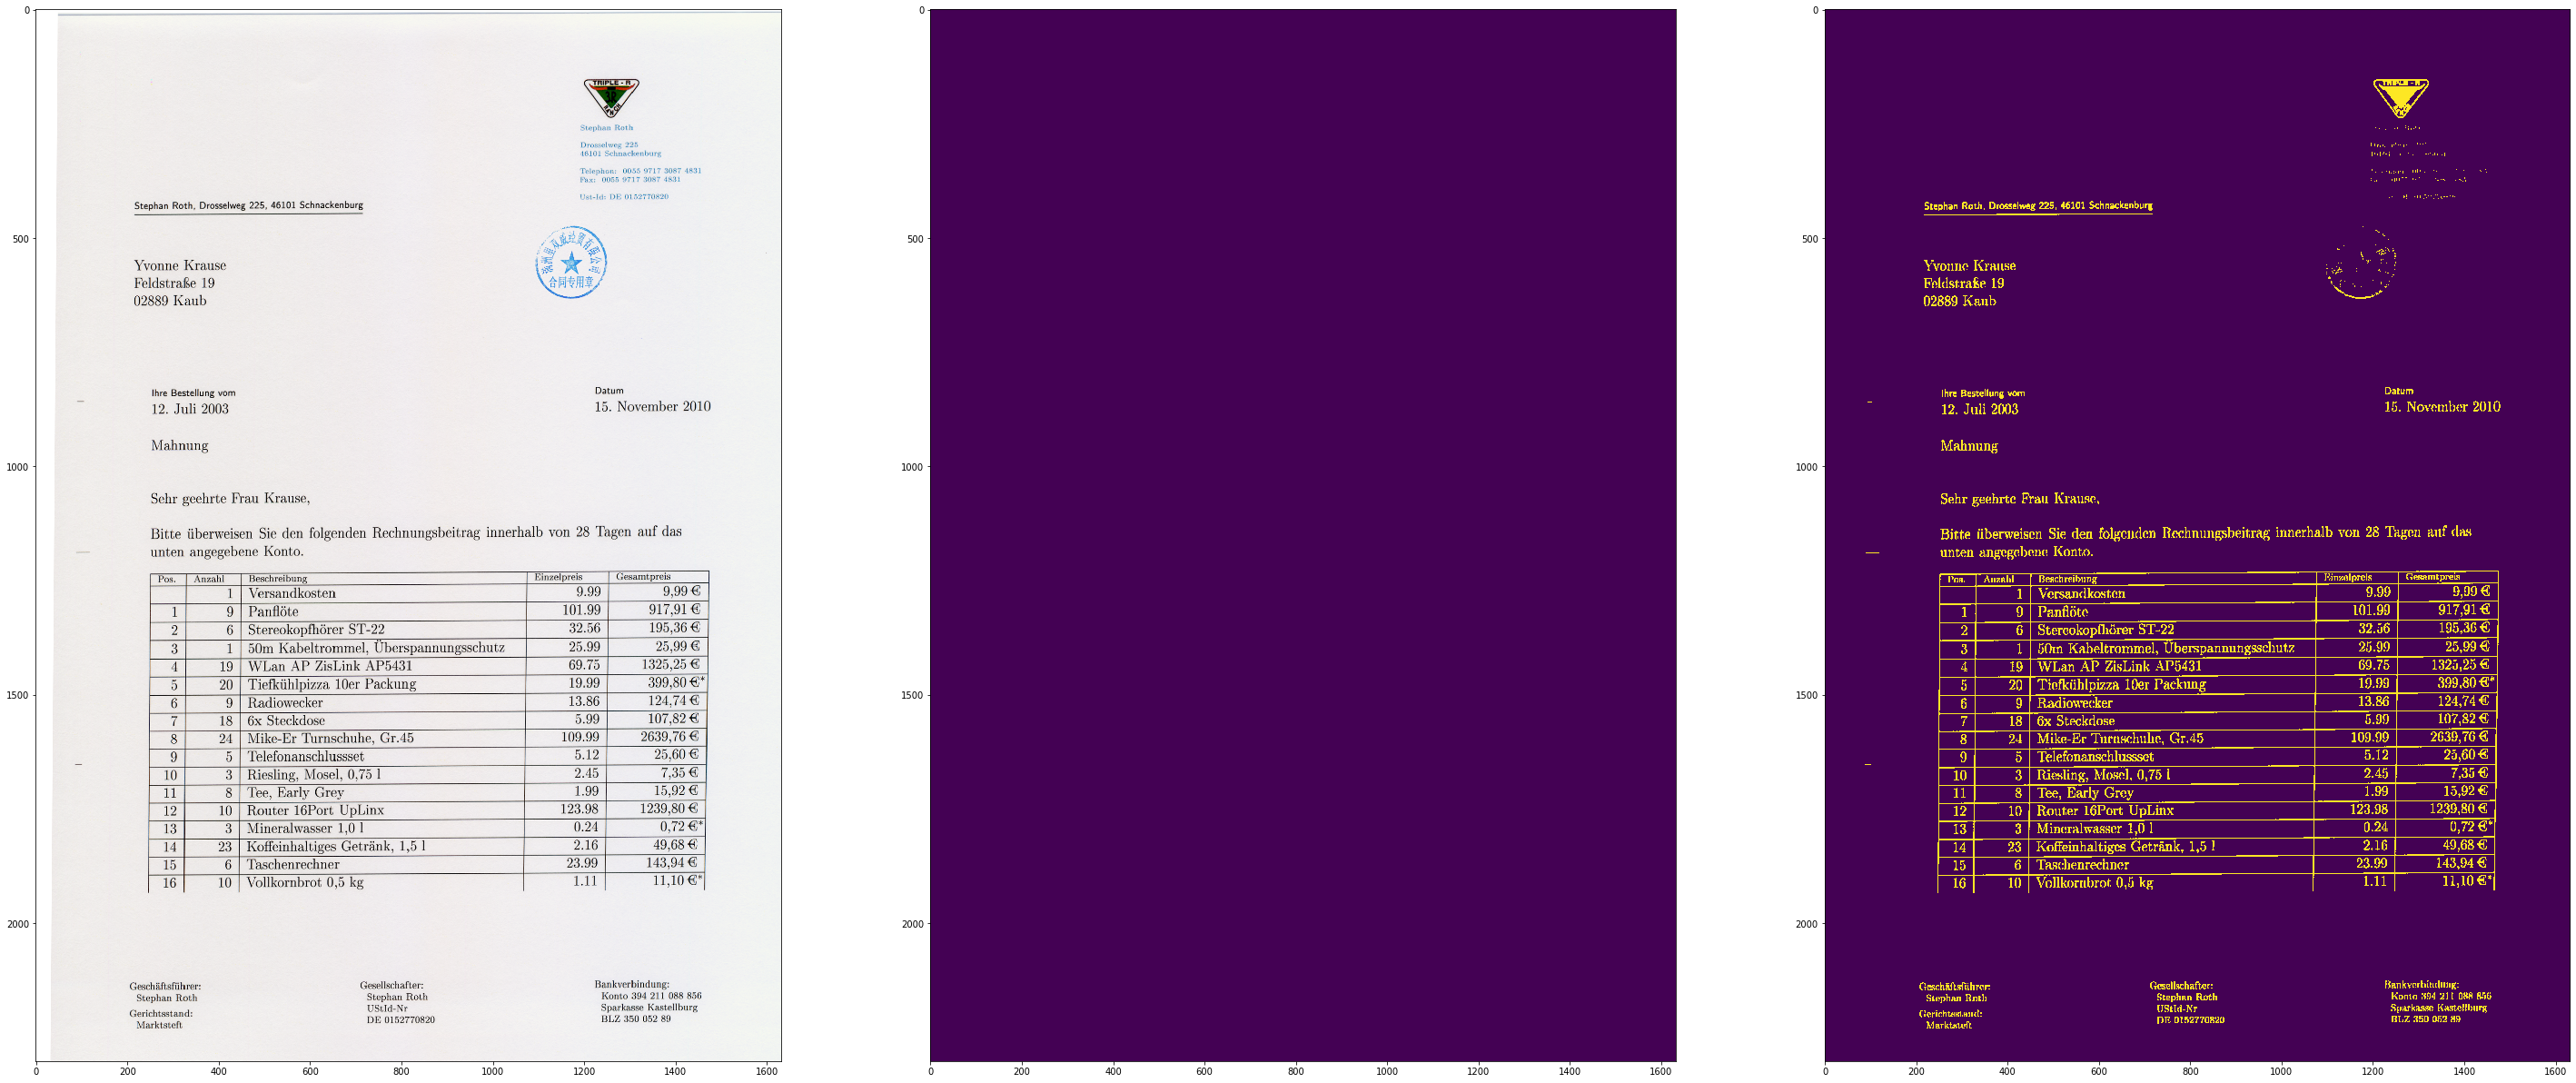

In [10]:
scans, labels, weights = next(image_generator(scan_files_train_selected, labels=truth_files_selected, include_weights=True, batch_size=1, augment=True, gamma_range=(0.8,0.8), jitter_range=50))

plt.figure(figsize=(50,50))
plt.subplot(1,3,1)
plt.imshow(scans[0]);
plt.subplot(1,3,2)
plt.imshow(labels[0].reshape((IMG_SIZE[0],IMG_SIZE[1])));
plt.subplot(1,3,3)
plt.imshow(weights[0].reshape((IMG_SIZE[0],IMG_SIZE[1])));

In [11]:
def make_model():
    inp = Input(IMG_SIZE)
    x = ZeroPadding2D(((1,1),(16,16)))(inp)
    skips=[]
    for n in [9,12,12]:
        skips.append(x)
        x = Conv2D(n, kernel_size=3,strides=2,activation='relu',padding='same')(x)
        x = BatchNormalization()(x)
    for n in [9,12]:
        x = UpSampling2D(size=2)(x)
        x = concatenate([x, skips.pop()])
        x = Conv2DTranspose(n, kernel_size=3,strides=1,activation='relu',padding='same')(x)
        x = BatchNormalization()(x)
    x = UpSampling2D(size=2)(x)
    x = concatenate([x, skips.pop()])
    x = Conv2DTranspose(1, kernel_size=3,strides=1,activation='sigmoid',padding='same')(x)
    x = Cropping2D(((1,1),(16,16)))(x)
    x = Reshape((IMG_SIZE[0]*IMG_SIZE[1],1,))(x)
    return Model(inp, x)

In [12]:
model = make_model()
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc'], sample_weight_mode="temporal")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2302, 1632, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 2304, 1664, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1152, 832, 9) 252         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1152, 832, 9) 36          conv2d_1[0][0]                   
____________________________________________________________________________________________

In [13]:
!rm *.hdf5

batch_size=1
epochs=90
checkpoint_period=30
model.fit_generator(image_generator(scan_files_train_selected, labels=truth_files_selected, include_weights=True, batch_size=1, augment=True, gamma_range=(0.8,1.25), jitter_range=50),
                    steps_per_epoch=len(scan_files_train_selected)//batch_size,
                    validation_data=image_generator(scan_files_train_selected, labels=truth_files_selected, include_weights=True, batch_size=1, augment=True, gamma_range=(0.8,1.25), jitter_range=50),
                    validation_steps=3,
                    max_queue_size=1,
                    epochs=epochs,
                    callbacks=[ModelCheckpoint('./stamp.weights.{epoch:04d}.hdf5', period=checkpoint_period, save_weights_only=True)],
                    verbose=1)

'rm' is not recognized as an internal or external command,
operable program or batch file.


Epoch 1/90
500/500 [==============================] - 1848s 4s/step - loss: 0.1239 - acc: 0.9697 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 2/90
500/500 [==============================] - 1896s 4s/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 0.9993
Epoch 3/90
500/500 [==============================] - 1942s 4s/step - loss: 8.0055e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9999
Epoch 4/90
500/500 [==============================] - 1895s 4s/step - loss: 4.3385e-04 - acc: 1.0000 - val_loss: 2.0172e-04 - val_acc: 1.0000
Epoch 5/90
500/500 [==============================] - 1808s 4s/step - loss: 1.8416e-04 - acc: 1.0000 - val_loss: 1.3082e-04 - val_acc: 1.0000
Epoch 6/90
500/500 [==============================] - 1751s 4s/step - loss: 1.1190e-04 - acc: 1.0000 - val_loss: 8.3743e-05 - val_acc: 1.0000
Epoch 7/90
500/500 [==============================] - 1742s 3s/step - loss: 7.8215e-05 - acc: 1.0000 - val_loss: 5.5037e-05 - val_acc: 1.0000
Epoch 8/90
500/500 [======

KeyboardInterrupt: 